We start by downloading an example dataset which was originally recorded by O'Doherty et al. (2018).
Here we consider a single recording session where we have binned the data in 25 ms bins in advance.
We have put this data on google drive for ease of access in this tutorial; note that the original dataset is available from https://zenodo.org/record/3854034#.YNCEy5P0nUI.

In [1]:
!mkdir -p data
!wget --no-check-certificate 'https://drive.google.com/u/2/uc?id=1kYJHADLpUVtBnLxlphk1ff3AC5UB21N-&export=download' -O data/test_data.tar.gz

--2023-11-10 12:56:06--  https://drive.google.com/u/2/uc?id=1kYJHADLpUVtBnLxlphk1ff3AC5UB21N-&export=download
Resolving drive.google.com (drive.google.com)... 142.250.179.238, 2a00:1450:4009:81d::200e
Connecting to drive.google.com (drive.google.com)|142.250.179.238|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1kYJHADLpUVtBnLxlphk1ff3AC5UB21N-&export=download [following]
--2023-11-10 12:56:06--  https://drive.google.com/uc?id=1kYJHADLpUVtBnLxlphk1ff3AC5UB21N-&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/958ed4o2d0huab5rcignci63vkv00hb5/1699620975000/03061924325282805644/*/1kYJHADLpUVtBnLxlphk1ff3AC5UB21N-?e=download&uuid=604fa59d-91a4-452b-a531-d3917d0b1776 [following]
--2023-11-10 12:56:18--  https://doc-0o-08-docs.googleusercontent.com/docs/se

We proceed to unzip the data and check that it has been correctly downloaded and decompressed. We should now have a ~110mb file named 'Doherty_example.pickled'.

In [2]:
!tar -xzvf data/test_data.tar.gz --directory data
!ls -ltrh data

Doherty_example.pickled
total 114M
-rw-r--r-- 1 ayush ayush 110M Jun 18  2021 Doherty_example.pickled
-rw-r--r-- 1 ayush ayush 3.9M Jun 18  2021 test_data.tar.gz


We proceed to install the Bayesian GPFA implementation used in Jensen & Kao et al. This is freely available but the codebase is still under active development with ongoing work on other latent variable models (here we use the 'bGPFA' branch and ignore other models).

That sets us up to actually run the code!
We start by loading a few packages and setting some default parameters.

In [3]:
import torch
import mgplvm as mgp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LinearRegression, Ridge
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
plt.rcParams['font.size'] = 20
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
np.random.seed(0)
torch.manual_seed(0)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU
from scipy.stats import poisson

loading


We proceed to load the data which we stored in a 'pickle' format.
While we could fit the full 30 minute dataset, it would take a bit too long for a real-time tutorial so we subsample both the number of time points and neurons, restricting our analysis to a single epoch of ~20 reaches and only considering neurons with high firing rates.

In [4]:
data = pickle.load(open('data/Doherty_example.pickled', 'rb')) # load example data
binsize = 25 # binsize in ms
timepoints = np.arange(0, 5000) #subsample ~40 seconds of data so things will run somewhat quicker
print(data['Y'].shape)
fit_data = {'Y': data['Y'][..., timepoints], 'locs': data['locs'][timepoints, :], 'targets': data['targets'][timepoints, :], 'binsize': binsize}
# fit_data = {'Y': data['Y'], 'locs': data['locs'], 'targets': data['targets'], 'binsize': binsize}
Y = fit_data['Y'] # these are the actual recordings and is the input to our model
targets = fit_data['targets'] # these are the target locations
locs = fit_data['locs'] # these are the hand positions
print(Y.shape)
Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 8, :] #subsample highly active neurons so things will run a bit quicker
print(Y.shape)
ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]
data = torch.tensor(Y).to(device) # put the data on our GPU/CPU
ts = np.arange(Y.shape[-1]) #much easier to work in units of time bins here
fit_ts = torch.tensor(ts)[None, None, :].to(device) # put our time points on GPU/CPU

# finally let's just identify bins where the target changes
deltas = np.concatenate([np.zeros(1), np.sum(np.abs(targets[1:, :] - targets[:-1, :]), axis = 1)])
switches = np.where(deltas > 1e-5)[0] # change occurs during time bin s
dswitches = np.concatenate([np.ones(1)*10, switches[1:] - switches[:-1]]) # when the target changes during a bin there will be two discontinuities
inds = np.zeros(len(switches)).astype(bool)
inds[dswitches > 1.5] = 1 # index of the bin where the target changes or the first bin with a new target
switches = switches[inds]

(1, 200, 70482)
(1, 200, 5000)
(1, 92, 5000)


We also plot the data to visually inspect how the firing rates of different neurons seem to (co)vary over time.

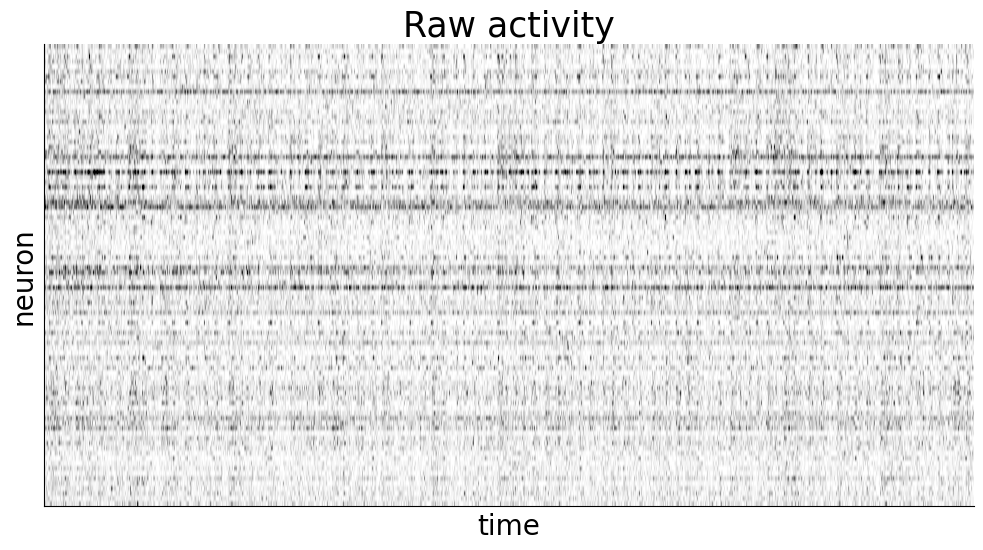

In [5]:
### plot the activity we just loaded ###
plt.figure(figsize = (12, 6))
plt.imshow(Y[0, ...], cmap = 'Greys', aspect = 'auto', vmin = np.quantile(Y, 0.01), vmax = np.quantile(Y, 0.99))
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('Raw activity', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
# AYUSH
rates = np.zeros(n)
for i in range(n):
    rates[i] = np.sum(Y[0,i]) / ((binsize/1000) * len(timepoints))
print(np.average(rates))
print(np.std(rates))

15.252086956521742
7.539422050926966


In the following code snippet, we set a couple of model parameters relating to the optimization process or initialization. Most of the initialization is done directly from the data but it can be useful to include if we have prior knowledge about e.g. the timescale of the behavior we care about.

In [7]:
### set some parameters for fitting ###
ell0 = 200/binsize # initial timescale (in bins) for each dimension. This could be the ~timescale of the behavior of interest (otherwise a few hundred ms is a reasonable default)
rho = 2 # sets the intial scale of each latent (s_d in Jensen & Kao). rho=1 is a natural choice with Gaussian noise; less obvious with non-Gaussian noise but rho=1-5 works well empirically.
max_steps = 1001 # number of training iterations
n_mc = 10 # number of monte carlo samples per iteration
print_every = 100 # how often we print training progress
d_fit = 20 # lets fit up to 10 latent dimensions (in theory this could be up to the number of neurons; should be thought of as an upper bound to how high-dimensional the activity is)

Having specified our parameters, we can construct the bGPFA model.
In this particular library, we need to separately specify (i) the noise model, (ii) the latent manifold (see Jensen et al. 2020 for LVMs on non-Euclidean manifolds), (iii) the prior and variational distribution (for GPFA, these are both Gaussian processes), and (iv) the observation model (for GPFA this is linear but see e.g. Wu et al. 2017 for non-linear LVMs).

For this dataset we use a negative binomial noise model which contains the Poisson model as a special case but also allows for overdispersed firing statistics.


In [8]:
### construct the actual model ###
ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]
lik = mgp.likelihoods.NegativeBinomial(n, Y=Y) # we use a negative binomial noise model in this example (recommended for ephys data)
manif = mgp.manifolds.Euclid(T, d_fit) # our latent variables live in a Euclidean space for bGPFA (see Jensen et al. 2020 for alternatives)
var_dist = mgp.rdist.GP_circ(manif, T, ntrials, fit_ts, _scale=1, ell = ell0, prior_fourier_func=mgp.rdist.prior_kernels.k_1_2_squared_exponential) # circulant variational GP posterior (c.f. Jensen & Kao et al. 2021)
lprior = mgp.lpriors.Null(manif) # here the prior is defined implicitly in our variational distribution, but if we wanted to fit e.g. Factor analysis this would be a Gaussian prior
mod = mgp.models.Lvgplvm(n, T, d_fit, ntrials, var_dist, lprior, lik, Y = Y, learn_scale = False, ard = True, rel_scale = rho).to(device) #create bGPFA model with ARD


This finally sets us up to train the model!
We will train it for only 1000 iterations and with a fairly high learning rate so it will finish in a reasonable amount of time.
We also define a function 'cb()' to intermittently print the learned scale parameters $\{ s_d \}$ which will go to zero for dimensions that are discarded by the ARD procedure.

In [9]:
## training will proceed for 1000 iterations (this takes ~2 minutes) ###
## OG
np.random.seed(1)
torch.manual_seed(1)
t0 = time.time()
def cb(mod, i, loss):
    """here we construct an (optional) function that helps us keep track of the training"""
    if i % print_every == 0:
        sd = np.log(mod.obs.dim_scale.detach().cpu().numpy().flatten())
        print('iter:', i, 'time:', str(round(time.time()-t0))+'s', 'log scales:', np.round(sd[np.argsort(-sd)], 1))
        # print(loss, mod.calc_LL(data = data, n_mc = n_mc))
# helper function to specify training parameters
train_ps = mgp.crossval.training_params(max_steps = max_steps, n_mc = n_mc, lrate = 5e-2, callback = cb)
print('fitting', n, 'neurons and', T, 'time bins for', max_steps, 'iterations')
mod_train = mgp.crossval.train_model(mod, data, train_ps)

fitting 92 neurons and 5000 time bins for 1001 iterations


iter   0 | elbo -0.919 | kl  0.000 | loss  0.919 | |mu| 0.051 | sig 1.000 | prior_ell 8.000 |scale 0.068 | lik_count 0.381 |
iter: 0 time: 1s log scales: [-1.5 -2.1 -2.4 -2.5 -2.7 -2.7 -2.7 -2.8 -2.8 -2.9 -3.  -3.  -3.  -3.
 -3.1 -3.1 -3.1 -3.2 -3.2 -3.3]
iter  50 | elbo -0.813 | kl  0.012 | loss  0.817 | |mu| 0.222 | sig 0.989 | prior_ell 7.959 |scale 0.066 | lik_count 0.441 |
iter 100 | elbo -0.790 | kl  0.010 | loss  0.794 | |mu| 0.219 | sig 0.996 | prior_ell 7.913 |scale 0.065 | lik_count 0.634 |
iter: 100 time: 57s log scales: [-1.5 -2.2 -2.4 -2.5 -2.7 -2.7 -2.8 -2.8 -2.9 -2.9 -3.  -3.  -3.  -3.1
 -3.1 -3.1 -3.1 -3.2 -3.3 -3.3]
iter 150 | elbo -0.769 | kl  0.009 | loss  0.775 | |mu| 0.216 | sig 1.007 | prior_ell 8.012 |scale 0.064 | lik_count 0.990 |
iter 200 | elbo -0.756 | kl  0.009 | loss  0.762 | |mu| 0.204 | sig 1.020 | prior_ell 8.395 |scale 0.063 | lik_count 1.531 |
iter: 200 time: 111s log scales: [-1.6 -2.1 -2.3 -2.4 -2.6 -2.6 -2.8 -2.9 -2.9 -3.  -3.1 -3.2 -3.2 -3.2
 -3.2

In [10]:
# ## Crossval
# # Y, fit_ts, rho, ell0, device, _, = self.training_setup(ind, rho, n_mc, print_every, max_steps, lrate)
# ### training will proceed for 1000 iterations (this takes ~2 minutes) ###
# t0 = time.time()
# def cb(mod, i, loss):
#     """here we construct an (optional) function that helps us keep track of the training"""
#     if i % print_every == 0:
#         sd = np.log(mod.obs.dim_scale.detach().cpu().numpy().flatten())
#         print('iter:', i, 'time:', str(round(time.time()-t0))+'s', 'log scales:', np.round(sd[np.argsort(-sd)], 1))

# lrate = 7.5e-2
# burnin = 50
# train_ps = mgp.crossval.training_params(max_steps = max_steps, n_mc = n_mc, burnin = burnin, lrate = lrate, callback = cb)

# mod, split = mgp.crossval.train_cv_bgpfa(Y = Y, 
#                                             device=device,
#                                             train_ps=train_ps,
#                                             fit_ts=fit_ts,
#                                             d_fit=d_fit,
#                                             ell=ell0,
#                                             likelihood='Poisson',
#                                             nt_train=None,
#                                             nn_train=None,
#                                             test=False)
# ### need to compute predictive likelihood ###

# Ycv, T1cv, N1cv = split['Y'], split['T1'], split['N1'] # all data, train data and train neurons
# m = T
# T2cv, N2cv = mgp.crossval.crossval.not_in(np.arange(m), T1cv), mgp.crossval.crossval.not_in(np.arange(n), N1cv) # these are our testing timepoints and neurons

# Ytest = Ycv[:, N2cv, :][..., T2cv]  #test data (shape ntrial x N2 x T2)

# latents = mod.lat_dist.lat_mu.detach().cpu()[:, T2cv, ...] # extract test latent means (shape ntrial, T2, d)
# # construct input for prediction of neural activity
# query = latents.transpose(-1, -2).to(device)  #(ntrial, d, m)

# # predicted 'F'
# mu = mod.svgp.predict(query[None, ...], full_cov = False)[0]
# # mean of the implied distribution after transfer function (for test neurons)
# Ypred = mod.svgp.likelihood.dist_mean(mu)[0].detach().cpu().numpy()[:, N2cv, :]

# # compute log probability of actual test spike counts given test mean predictions
# LL = poisson.logpmf(Ytest, Ypred, loc=0)
# LL = np.mean(LL) # take avg

# # also compute MSEs
# MSE_vals = np.mean((Ypred - Ytest)**2, axis=(0, -1))
# MSE = np.mean(MSE_vals)  #standard MSE

# print('log likelihood:', LL, 'MSE:', MSE)

Now we're ready to analyze our new model. We start by plotting the posterior mean against the prior scales ${s_d}$ to see how informative the different latent dimensions are (upper right corner indicates more informative dimensions).

plotting informative and discarded dimensions


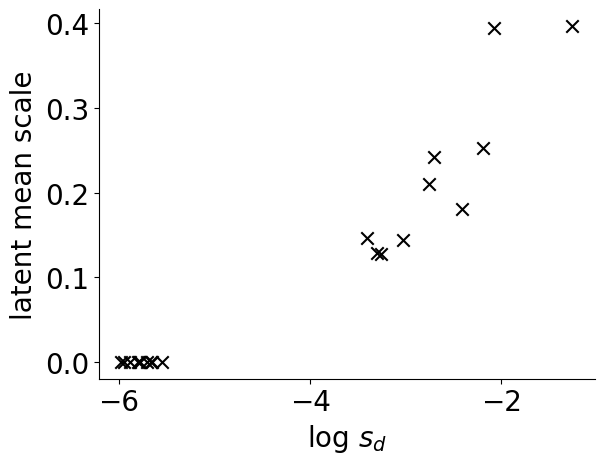

In [11]:
### we start by plotting 'informative' and 'discarded' dimensions ###
print('plotting informative and discarded dimensions')
dim_scales = mod.obs.dim_scale.detach().cpu().numpy().flatten() #prior scales (s_d)
dim_scales = np.log(dim_scales) #take the log of the prior scales
nus = np.sqrt(np.mean(mod.lat_dist.nu.detach().cpu().numpy()**2, axis = (0, -1))) #magnitude of the variational mean
plt.figure()
plt.scatter(dim_scales, nus, c = 'k', marker = 'x', s = 80) #top right corner are informative, lower left discarded
plt.xlabel(r'$\log \, s_d$')
plt.ylabel('latent mean scale', labelpad = 5)
plt.show()

We proceed to plot the posterior latent mean in the two most informative dimensions (i.e. the ones with the highest $s_d$) for a subset of the behavior.
We contrast this with FA which yields discontinuous trajectories dominated by noise since the model is unable to share information across time bins.

plotting latent trajectories


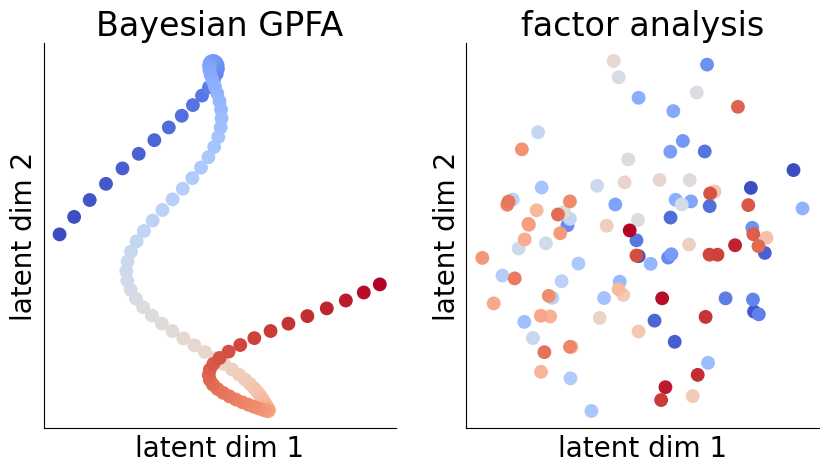

learned timescales (ms): [147  81 241 589 167 269 617 775 690 259 319 270 301 291 277 249 194 220
 248 232]


In [12]:
### plot the inferred latent trajectories
print('plotting latent trajectories')
X = mod.lat_dist.lat_mu.detach().cpu().numpy()[0, ...] # extract inferred latents ('mu' has shape (ntrials x T x d_fit))
X = X[..., np.argsort(-dim_scales)] # only consider the two most informative dimensions (c.f. Jensen & Kao)
tplot = np.arange(300, 400) # let's only plot a shorter period (here 2.s) so it doesn't get too cluttered

# fit FA for comparison
fa = FactorAnalysis(2)
Xfa = fa.fit_transform(np.sqrt(Y[0, ...].T)) # sqrt the counts for variance stabilization (c.f. Yu et al. 2009)

i1, i2 = 2, 3 # which dimensions to plot
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].scatter(X[tplot, i1], X[tplot, i2], c = tplot, cmap = 'coolwarm', s = 80) # plot bGPFA latents
axs[1].scatter(Xfa[tplot, 0], Xfa[tplot, 1], c = tplot, cmap = 'coolwarm', s = 80) # plot FA latents
for ax in axs:
    ax.set_xlabel('latent dim 1')
    ax.set_ylabel('latent dim 2')
    ax.set_xticks([])
    ax.set_yticks([])
axs[0].set_title('Bayesian GPFA')
axs[1].set_title('factor analysis')
plt.show()

# let's also print the learned timescales (sorted by the prior scales s_d)
taus = mod.lat_dist.ell.detach().cpu().numpy().flatten()[np.argsort(-dim_scales)]*binsize
print('learned timescales (ms):', np.round(taus).astype(int))

To make sense of our latent trajectories, it may be useful to also take into account what's actually occurring at the level of behavior.
We therefore start by visualizing the hand kinematics during the period of reaching considered for the latent trajectories above.
We can visualize both the position of the hand as it changes over time as well as the instantaneous velocity in the x and y directions.

(5000, 2)


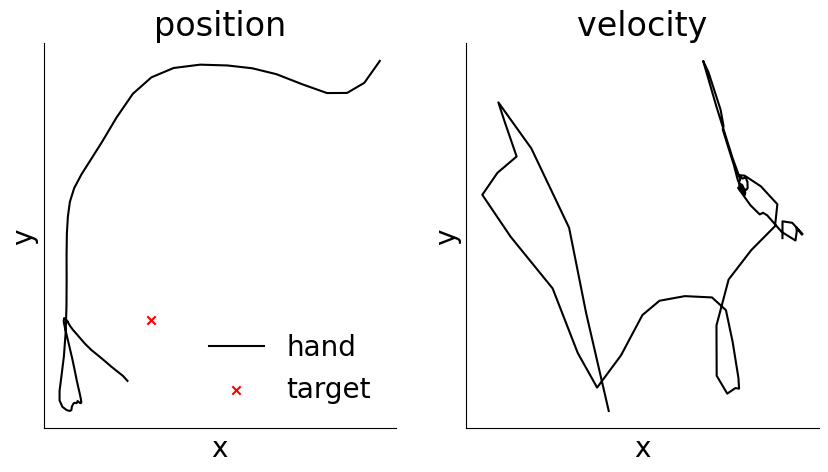

In [13]:
ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior
vels = cs(ts, 1) # velocity (first derivative)
print(vels.shape)

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].plot(locs[tplot, 0], locs[tplot, 1], 'k-') # plot position

for s in switches: # plot the targets
  if s in tplot:
    axs[0].scatter([targets[s+1, 0]], [targets[s+1, 1]], marker = 'x', c = 'r')
axs[0].legend(['hand', 'target'], frameon = False)

axs[1].plot(vels[tplot, 0], vels[tplot, 1], 'k-') # plot velocity
for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xticks([])
    ax.set_yticks([])
axs[0].set_title('position')
axs[1].set_title('velocity')
plt.show()

Finally we might ask whether our latent trajectories can predict the behavioral output.
To investigate this, we train a linear decoder to predict the hand kinematics from the inferred firing rates $\hat{\bf Y}$.
This can also be seen as a non-linear decoder from the latent trajectories ${\bf X}$ where the first layer of the decoder is giving by the learned observation model.
We fit a decoder with different delays between neural activity and behavior from -150ms (activity lags behavior) to +250ms (activity precedes behavior).
We do this to find the 'optimal delay' between neural activity and behavior and show that cortical activity seems to predict behavior ~100 ms into the future.

running decoding analysis
plotting decoding
0.6453874329434277


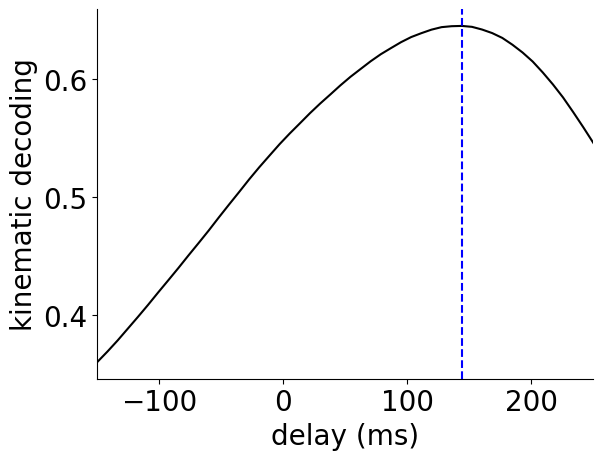

In [14]:
### finally let's do a simple decoding analysis ###
torch.cuda.empty_cache() # clear GPU memory
print('running decoding analysis')
Ypreds = [] # decode from the inferred firing rates (this is a non-linear decoder from latents)
query = mod.lat_dist.lat_mu.detach().transpose(-1, -2).to(device)  # (ntrial, d_fit, T)
for i in range(10): # loop over mc samples to avoid memory issues
    Ypred = mod.svgp.sample(query, n_mc=10, noise=False) # OG n_mc = 100
    Ypred = Ypred.detach().mean(0).cpu().numpy()  # (ntrial x n x T)
    Ypreds.append(Ypred)
Ypred = np.mean(np.array(Ypreds), axis = (0,1)).T # T x n

delays = np.linspace(-150, 250, 50) # consider different behavioral delays
performance = np.zeros((len(delays), 2)) # model performance
for idelay, delay in enumerate(delays):
    vels = cs(ts+delay, 1) # velocity at time+delay
    for itest, Ytest in enumerate([Ypred]): # bGPFA
    #   regs = [Ridge(alpha=1e-3).fit(Ytest[::2, :], vels[::2, i]) for i in range(2)] # fit x and y vel on half the data
    #   scores = [regs[i].score(Ytest[1::2, :], vels[1::2, i]) for i in range(2)] # score x and y vel on the other half
        regs = [Ridge(alpha=1e-3).fit(Ytest, vels[:, i]) for i in range(2)]
        scores = [regs[i].score(Ytest, vels[:, i]) for i in range(2)]
        performance[idelay, itest] = np.mean(scores) # save performance
print('plotting decoding')
plt.figure()
plt.plot(delays, performance[:, 0], 'k-')
print(max(performance[:, 0]))
plt.axvline(delays[np.argmax(performance[:, 0])], color = 'b', ls = '--')
plt.xlim(delays[0], delays[-1])
plt.xlabel('delay (ms)')
plt.ylabel('kinematic decoding')
plt.show()


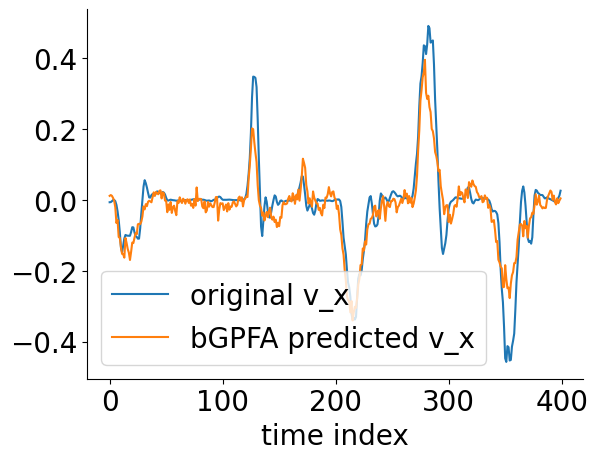

In [15]:
start = 1200 #0//binsize
end = 1600 # 50000//binsize
best_delay = delays[np.argmax(performance[:, 0])]
vels = cs(ts+best_delay, 1)
regs = [Ridge(alpha=1e-3).fit(Ypred, vels[:, i]) for i in range(2)]
preds = regs[0].predict(Ypred[start:end, :])
# Y_new = Y[0].T
# regs = [Ridge(alpha=1e-3).fit(Y_new, vels[:, i]) for i in range(2)]
# preds = regs[0].predict(Y_new[start:end, :])
plt.plot(vels[start:end, 0], label='original v_x')
# plt.plot(vels[start:end, 1])
plt.plot(preds, label='bGPFA predicted v_x')
plt.legend()
plt.xlabel('time index')
plt.show()

# # Question is MSE really a good metric? Look at plot below to justify
# regs = [Ridge(alpha=1e-3).fit(Y_new, vels[:, i]) for i in range(2)]
# scores = [regs[i].score(Y_new, vels[:, i]) for i in range(2)]
# print(np.mean(scores))

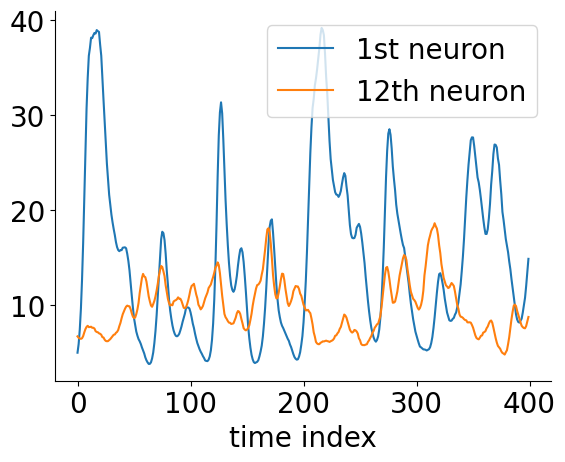

In [16]:
start = 1200 #0//binsize
end = 1600 # 50000//binsize
delta_t = 0.025
plt.plot(Ypred[start:end, 0]/delta_t, label='1st neuron')
plt.plot(Ypred[start:end, 12]/delta_t, label='12th neuron')
# plt.plot(Ypred[start:end, 110]/delta_t, label='12th neuron')
plt.legend()
plt.xlabel('time index')
plt.show()

In Jensen & Kao et al. (2021), we carry out further analyses on multi-region recordings, preparatory dynamics and reaction times for bGPFA models fitted to the full reaching dataset which the interested reader can look at further.
However, we hope that this short notebook has given an introduction to GPFA and its Bayesian extension as well as some insight into the possible use cases for such models.